# Некоторые итоги практики

В отчете я собираюсь написать некоторый обзор методов, которые используют серьезные люди, я же в практической реализации остановилась на преобразовании Фурье, используя по ходу дела некоторые вещи, которым научилась за этот год.

А тут я немного прокомментировала то, что я, собственно, сделала.

In [1]:
# импорты
from math import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate
import random
from IPython.display import clear_output
import os
from tqdm import *

## Подбор функций и генерация шумов

Я тестировала свой метод на синтетических сигналах разного рода, добавляя в них шумы. Для наглядной демонстрации результатов я взяла три рода функций, добавила в них шумы:

In [2]:
# развлечения с шумами

def add_sin(f, level):
    if level == 0:
        return f
    w1 = random.uniform(0, 0.01)
    a1 = random.uniform(0, 100)
    ff = add_sin(f, level - 1)
    return lambda x : ff(x) + w1 * sin(a1 * x)

def modify(f):
    mult = random.uniform(0.9, 1.1)
    shift = random.uniform(-0.1, 0.1)
    shift2 = random.uniform(-0.1, 0.1)
    ff = add_sin(lambda x : 0, 20)
    return lambda x: mult * f(x - shift) + ff(x) + shift2

#рисовашки

def draw(f):
    x = np.linspace(0, pi, 1000)
    y = [f(i) for i in x]
    plt.plot(x, y)
    plt.show()

Первая и четвертая функции похожи по структуре. Пусть отрицательной интенсивности волны не бывает, эта штука просто для демонстрации эффективности кластеризации:

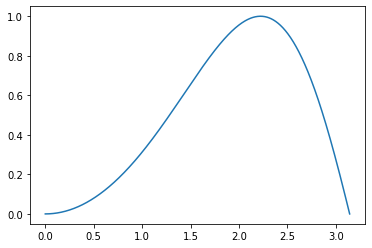

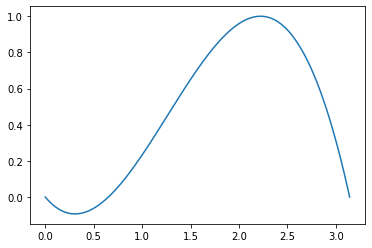

In [3]:
def f1(x):
    x = x / pi
    return sin(x**2 * pi)

draw(f1)

def f4(x):
    x = x / pi
    return -4 * (1 + sqrt(2)) * x**3 + (6 + 4 * sqrt(2)) * x**2 - 2 * x

draw(f4)

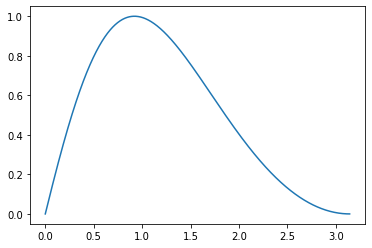

In [4]:
def f2(x):
    x = x / pi
    return sin((x - 1)**2 * pi)

draw(f2)

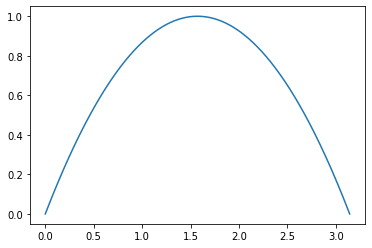

In [5]:
def f3(x):
    x = x / pi
    return -x * (x - 1) * 4

draw(f3)

Теперь исказим сигналы:

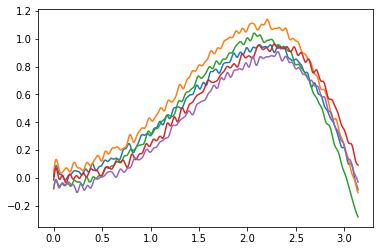

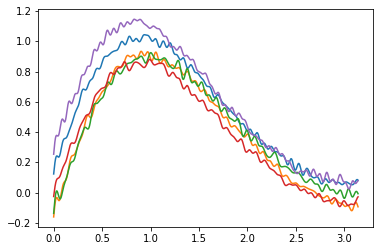

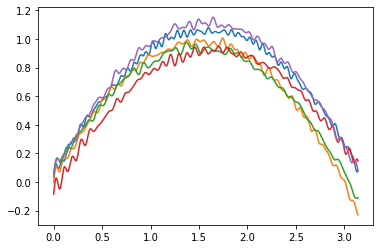

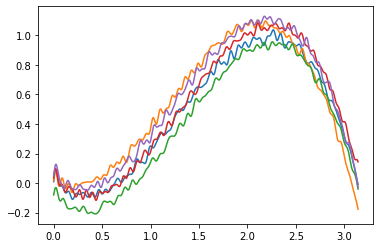

In [6]:
L, R = 0, pi

x = np.linspace(L, R, 10000)
y = []

funcs = []

for i in range(100):
    mf = modify(f1)
    y = [mf(i) for i in x]
    if i < 5:
        plt.plot(x, y)
    funcs += [mf]

plt.show()

for i in range(100):
    mf = modify(f2)
    y = [mf(i) for i in x]
    if i < 5:
        plt.plot(x, y)
    funcs += [mf] 
    
plt.show()    
    
for i in range(100):
    mf = modify(f3)
    y = [mf(i) for i in x]
    if i < 5:
        plt.plot(x, y)
    funcs += [mf] 
    
plt.show()    
    
for i in range(100):
    mf = modify(f4)
    y = [mf(i) for i in x]
    if i < 5:
        plt.plot(x, y)
    funcs += [mf]     

## Теперь самое важное - ряд Фурье

Я представила все функции как стандартную сумму:

$$f(x)=\frac{a_0}{2} + \sum^{\infty}_{n=1} (a_n \cos nx + b_n \sin nx)$$

И посчитала нулевой коэффициент и коэффициенты при косинусах по стандартной интегральной формуле. Так как сигнал как некая временная функция определен только на положительном промежутке, мы вправе доопределить ее как четную. 

Тогда интеграл с косинусом: ($a_n= \frac{1}{\pi}\int\limits_{-\pi}^{\pi}f(x)\cos(nx)dx$) не поменяется. 

А интеграл с синусом: ($b_n= \frac{1}{\pi}\int\limits_{-\pi}^{\pi}f(x)\sin(nx)dx$) станет нулевым (четная функция на нечетную функцию дает нечетную функцию).

In [7]:
# обработка и получение коэффициентов

def get_features(f, k=2):
    res = np.array([integrate.quad(lambda x : f(x) * cos(i * x), 0, pi)[0] for i in range(k)]) * 2 / pi
    res[0] = res[0] / 2
    return res

Можно порисовать красивые картиночки и посмотреть, как хорошо эта сумма начинает приближать сигнал (а без добавления некоторого количества высокочастотных слагаемых очень хорошо убирает шум). Возьмем одну из функций для примера.

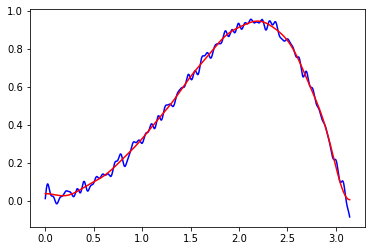

[ 0.48343445 -0.29465599 -0.28518051  0.17732955 -0.09436323  0.05768976
 -0.03644678  0.02868527 -0.01852208  0.01564821 -0.01110444  0.01128782
 -0.00705251  0.00911975 -0.00464695  0.00562341 -0.00302634  0.00513504
 -0.00188388]


In [8]:
def func(x, a):
    ans = 0
    for i in range(len(a)):
        ans += a[i] * cos(i * x)
    return ans

for k in range(1, 20):
    
    a = get_features(funcs[0], k)
    y_ours = [func(i, a) for i in x]
    y_true = [funcs[0](i) for i in x]
    
    clear_output(True)
    plt.plot(x, y_true, color='blue')
    plt.plot(x, y_ours, color='red')   
    plt.show()  
print(a)    

## Кластеризация

Так как все функции теперь унифицированы (их признаками мы считаем коэффициенты перед функциями косинусов, в дальнейшем, при работе с реальными данными, можно добавить длину сигнала или же максимальное значение), мы можем отобрать наиболее значимые признаки для кластеризации. Для этого я использую SVD-разложение матрицы, которая по строкам содержит признаки конкретных функций из выборки. 

In [9]:
# получаем все признаки

A = np.array([get_features(i, 10) for i in funcs])

In [10]:
# SVD и кластеры
B = A.copy()
B = np.subtract(B, B.mean(axis=0))
U, S, VT = np.linalg.svd(B, full_matrices=False)
print(S)

[6.98187103 2.21007827 0.98308699 0.61613456 0.22720564 0.08839784
 0.05951575 0.05619762 0.05336694 0.04710647]


Выше я вывела сигму - столбец признаков. Можно заметить, что первые два признака сильно больше остальных. Выдвину гипотезу, что я могу оставить только их и получить нужную кластеризацию. Так как оставляю всего два признака, удобно все классы функций расположить на плоскости.

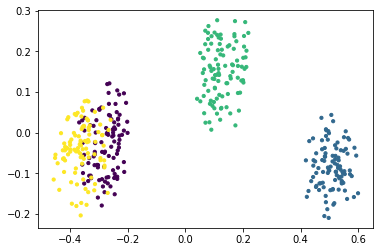

In [11]:
# в parse_data я составляю картинку, описывающую функцию, заново, а потом рисую ее

def parse_data():
    return U[:, :2].dot(np.diag(S[:2]))

def draw_data(data):
    x, y = data.T
    colours = plt.cm.rainbow(np.linspace(0, 1, 2))
    c = [i // 100 for i in range(len(funcs))]
    plt.scatter(x, y, c=c, s=10)
    plt.show()
    
draw_data(parse_data())  

Как видно, первый и четвертый классы функций очень хорошо совместились, а все фундаментально различающиеся классы разделились.

In [12]:
from astropy.io import fits
fits_table_filename = 'C:\\Users\\hikka\\Downloads\\flare106440.fits'

hdul = fits.open(fits_table_filename)  # open a FITS file
data = hdul[1].data  # assume the first extension is a table
first_two_rows = data[:]


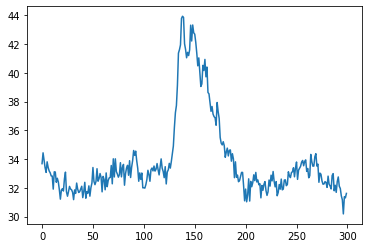

In [13]:
x = []
y = []
for a, b in data:
    x.append(a)
    y.append(b)   
plt.plot(x, y)
plt.show()

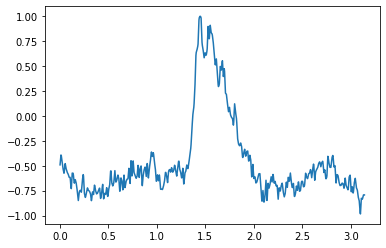

In [14]:
funcs = []
all_dots = []
rootdir = 'C:\\Users\\hikka\\Downloads\\flare_sims-master'
maxes = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        # print(os.path.join(subdir, file))
        hdul = fits.open(os.path.join(subdir, file))
        data = hdul[1].data
        x = []
        y = []
        for a, b in data:
            x.append(a)
            y.append(b)
        y = np.array(y)
        maxes += np.max(y)
        y -= np.min(y)
        y /= np.max(y) / 2
        y -= 1
        all_dots.append(y.copy())        

def x_change(x, y):
    x = x / pi * 300
    L = max(0, int(min(298, x)))
    R = L + 1
    delta = max(0, min(1, x - L))
    return y[L] + delta * (y[R] - y[L])
    
def init_func(i):
    return lambda x: x_change(x, all_dots[i])
    
funcs = [init_func(i) for i in range(len(all_dots))]  

x = np.linspace(0, pi, 1000)
plt.plot(x, [funcs[0](i) for i in x])
plt.show()  

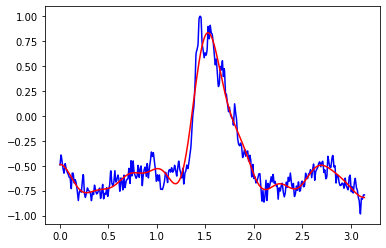

In [15]:
for k in range(1, 20):
    
    a = get_features(funcs[0], k)
    y_ours = [func(i, a) for i in x]
    y_true = [funcs[0](i) for i in x]
    
    clear_output(True)
    plt.plot(x, y_true, color='blue')
    plt.plot(x, y_ours, color='red')   
    plt.show() 

In [16]:
A = np.array([get_features(i, 50)[1:] for i in tqdm(funcs)])
print(A)
B = A.copy()
B = np.subtract(B, B.mean(axis=0))
U, S, VT = np.linalg.svd(B, full_matrices=False)
print(S)

  0%|                                                                                          | 0/219 [00:00<?, ?it/s]<ipython-input-7-35486a4758c7>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res = np.array([integrate.quad(lambda x : f(x) * cos(i * x), 0, pi)[0] for i in range(k)]) * 2 / pi
<ipython-input-7-35486a4758c7>:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res = np.array([integrate.quad(lambda x : f(x) * cos(i * x), 0, pi)[0] for i in range(k)]) * 2 / pi
100%|█████████████████████████████████████████████████████████████████████

[[-0.00136231 -0.36210688 -0.01915516 ... -0.01208229  0.01487955
   0.02073642]
 [ 0.35420002 -0.1097251   0.04050397 ...  0.00309849  0.00599152
   0.00962952]
 [ 0.14875438  0.08263811  0.06594166 ... -0.01528467 -0.01129296
  -0.00211111]
 ...
 [ 0.10586501 -0.38997373 -0.22553982 ... -0.00529855 -0.00466607
   0.00411137]
 [ 0.09554743 -0.04697436 -0.09177424 ... -0.02618473 -0.02707747
  -0.00338172]
 [ 0.06711011 -0.04031325 -0.11869095 ...  0.01499225  0.01168664
   0.01149735]]
[3.12437193 2.75147426 1.85626612 1.72698643 1.42904242 1.22071281
 1.05816696 1.03477987 0.96275817 0.8745787  0.80114126 0.74561629
 0.68739273 0.63362687 0.60075361 0.5866974  0.53734047 0.52400648
 0.49472881 0.47260218 0.45306296 0.44872859 0.42502128 0.41710554
 0.40531436 0.39833086 0.37783449 0.36245545 0.34719088 0.33873807
 0.32548896 0.31936647 0.30072568 0.30063896 0.2870189  0.2831759
 0.26980598 0.26218565 0.25418404 0.24153344 0.23872264 0.21975235
 0.2108675  0.20190545 0.19513324 0.1842

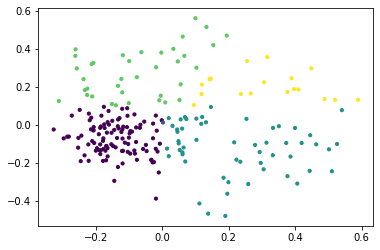

In [30]:
comp1 = []
comp2 = []
comp3 = []
comp4 = []
comp5 = []


def draw_data1(data):
    x, y = data.T
    colours = plt.cm.rainbow(np.linspace(1, 2, 7))
    c = [0 for i in range(len(y))]
    for i in range(len(y)):
        xi, yi = x[i], y[i]
        if xi < 0 and yi < 0.1:
            c[i] = 0
            comp1.append(i)
        elif yi < 0.1 and yi >= 2 * xi:
            c[i] = 1
            comp2.append(i)
        elif yi < 0.1 and yi < 2 * xi:
            c[i] = 2
            comp3.append(i)
        elif yi >= 2 * xi:
            c[i] = 3
            comp4.append(i)
        else:
            c[i] = 4
            comp5.append(i)
    plt.scatter(x, y, c=c, s=10)
    plt.show()
    

draw_data1(parse_data())

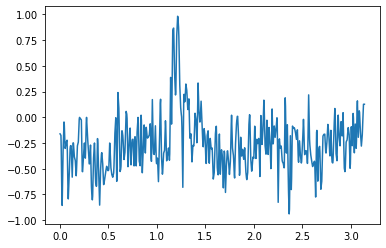

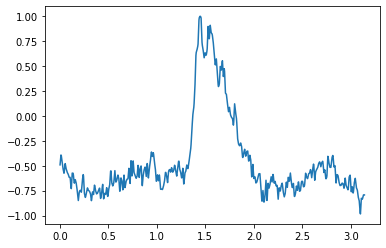

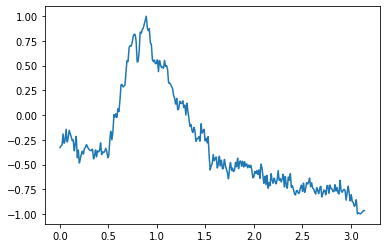

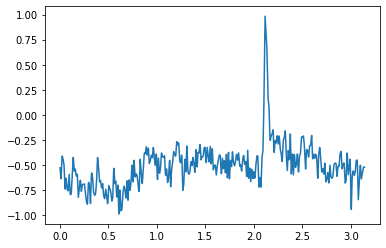

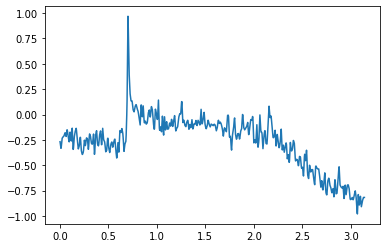

In [34]:
i1 = random.randrange(len(comp1))
i2 = random.randrange(len(comp2))
i3 = random.randrange(len(comp3))
i4 = random.randrange(len(comp4))
i5 = random.randrange(len(comp5))

draw(funcs[i1])
draw(funcs[i2])
draw(funcs[i3])
draw(funcs[i4])
draw(funcs[i5])